In [95]:
# so we can use packages from parent directory
import sys
sys.path.append("..")

In [96]:
# code copied from example experiments.py
import torch
import torch.nn as nn
import numpy as np
from monroe_data import MonroeData, MonroeDataEntry, Color # last two for reading pkl file
import caption_featurizers
from color_featurizers import ColorFeaturizer, color_phi_fourier
from models import LiteralListener, LiteralSpeaker, ImaginativeListener, PragmaticListener, CaptionEncoder, CaptionGenerator, ColorGenerator

import importlib
import evaluation
importlib.reload(evaluation)
from evaluation import score_model, delta_e_dist, Speaker, Score
from experiment import FeatureHandler, evaluate_model

In [97]:
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline

In [98]:
from functools import partial
import importlib

In [99]:
import evaluation
importlib.reload(evaluation)
from evaluation import score_model, delta_e_dist, Speaker, Score

In [100]:
prefix="../"
train_data = MonroeData(prefix + "data/csv/train_corpus_monroe.csv", prefix + "data/entries/train_entries_monroe.pkl")
dev_data = MonroeData(prefix + "data/csv/dev_corpus_monroe.csv", prefix + "data/entries/dev_entries_monroe.pkl")
dev_data_synth  = MonroeData(prefix + "data/csv/dev_corpus_synth_10fold.csv", prefix + "data/entries/dev_corpus_synth_10fold.pkl")

In [46]:
# 1. Literal Listener
# -----------------------------------------
def literal_listener_experiment(train=False, evaluate=True, composite=False, epochs=5, embed_dim = 100, hidden_dim = 100, color_dim= 54, model_file="../model/literal_listener_5epoch_endings_tkn.params"):

    # Initializing featurizers
    print("Initializing featurizers")
    caption_phi = caption_featurizers.CaptionFeaturizer(tokenizer=caption_featurizers.EndingTokenizer) # Use with parameter files that end in `endings_tkn`
    # caption_phi = caption_featurizers.CaptionFeaturizer(tokenizer=caption_featurizers.WhitespaceTokenizer) # Use with parameter files don't
    color_phi = ColorFeaturizer(color_phi_fourier, "rgb", normalized=True)
    feature_handler = FeatureHandler(train_data, dev_data_synth, caption_phi, color_phi) # target function is initialized by default

    print("Obtaining training features") # get features even if you're runnning the pretrained model for example
    train_features = feature_handler.train_features()
    train_targets = feature_handler.train_targets()

    print("Initializing model")
    model = LiteralListener(CaptionEncoder, num_epochs = epochs)
    model.init_model(embed_dim = embed_dim, hidden_dim = hidden_dim, vocab_size = feature_handler.caption_featurizer.caption_indexer.size,
                 color_dim = color_dim)

    # to train: (probably takes about 15 min - 2 hrs) depending on # of epochs (5 - 30)
    if train:
        print("Training model and saving to {}:".format(model_file))
        model.fit(train_features, train_targets)
        model.save_model(model_file)
    else:
        print("Loading pretrained model")
        model.load_model(model_file)

    if not evaluate:
        return model
    else:
        # convert the model output to a score for that particular round
        print("Evaluating model")
        output_to_score = lambda model_outputs, targets: np.exp(model_outputs[np.arange(len(model_outputs)), targets]) # get the model's predicted probablity at each target index and use that as the score
        if composite:
            my_score_model = partial(score_model, speaker=Speaker.BY_GAME_ID_COND, return_df=True, score=Score.COMPOSITE)
        else:
            my_score_model = partial(score_model, speaker=Speaker.BY_GAME_ID_COND, return_df=True)
        return evaluate_model(dev_data_synth, feature_handler, model, output_to_score, my_score_model)
    
    
    
    

In [14]:
x = literal_listener_experiment(model_file="../model/literal_listener_5epoch_endings_tkn.params", composite=True)

Initializing featurizers
Obtaining training features
Initializing model
Loading pretrained model
Evaluating model
Got here to composite score
temp3 1.0
temp2 0.40476274387475697
temp 0.7380513537308606
((0.8360841261959121, 0.0),           gameid  roundNum  numOutcome  \
0        synth-0         1           1   
1        synth-0         2           1   
2        synth-0         3           1   
3        synth-0         4           1   
4        synth-0         5           1   
5        synth-0         6           1   
6        synth-0         7           1   
7        synth-0         8           1   
8        synth-0         9           1   
9        synth-0        10           1   
10       synth-0        11           1   
11       synth-0        12           1   
12       synth-0        13           1   
13       synth-0        14           1   
14       synth-0        15           1   
15       synth-0        16           1   
16       synth-0        17           1   
17       synth

In [47]:
x = literal_listener_experiment(composite=True)
literal_listener_eval_composite = x[1]
# first get just correlation between all model scores 
ll_true_scores = literal_listener_eval_composite.groupby('gameid').numOutcome.mean()
ll_model_scores = literal_listener_eval_composite.groupby('gameid').model_scores.mean()

Initializing featurizers
Obtaining training features
Initializing model
Loading pretrained model
Evaluating model
Got here to composite score
((0.8360841262935983, 0.0),           gameid  roundNum  numOutcome  \
0        synth-0         1           1   
1        synth-0         2           1   
2        synth-0         3           1   
3        synth-0         4           1   
4        synth-0         5           1   
5        synth-0         6           1   
6        synth-0         7           1   
7        synth-0         8           1   
8        synth-0         9           1   
9        synth-0        10           1   
10       synth-0        11           1   
11       synth-0        12           1   
12       synth-0        13           1   
13       synth-0        14           1   
14       synth-0        15           1   
15       synth-0        16           1   
16       synth-0        17           1   
17       synth-0        18           1   
18       synth-0        19      

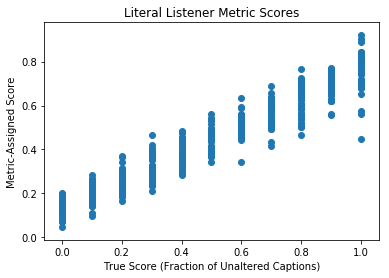

(0.9642146039293128, 4.3350106400901717e-299)

In [48]:
plt.scatter(ll_true_scores, ll_model_scores)
plt.title("Literal Listener Metric Scores")
plt.xlabel("True Score (Fraction of Unaltered Captions)")
plt.ylabel("Metric-Assigned Score")
plt.show()
stats.pearsonr(ll_true_scores, ll_model_scores)

In [49]:
stats.pearsonr(ll_true_scores, ll_model_scores)

(0.9642146039293128, 4.3350106400901717e-299)

In [50]:
# now calculate the composite score from the eval_df we get back:
def composite_score(eval_df, speaker="gameid"):
    mean_scores = eval_df.groupby(speaker).numOutcome.mean()
    mean_numCleanWords = eval_df.groupby(speaker).numCleanWords.mean()
    mean_clkTime = eval_df.groupby(speaker).clkTime.mean()
    true_scores = mean_scores / mean_clkTime / mean_numCleanWords
    max_score = true_scores.max()
    true_scores /= max_score # normalize the scores
    return true_scores

ll_true_scores_composite = composite_score(literal_listener_eval_composite)
literal_listener_eval_composite.groupby('gameid').numOutcome.mean()
ll_model_scores_composite = literal_listener_eval_composite.groupby('gameid').model_scores.mean()

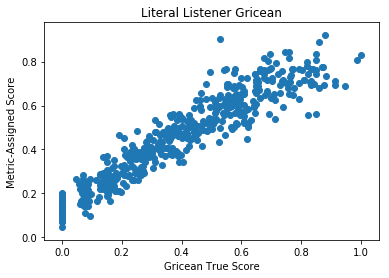

(0.9447046164538164, 1.5582147887200809e-251)

In [51]:
plt.scatter(ll_true_scores_composite, ll_model_scores_composite)
plt.title("Literal Listener Gricean")
plt.xlabel("Gricean True Score")
plt.ylabel("Metric-Assigned Score")
plt.show()
stats.pearsonr(ll_true_scores_composite, ll_model_scores_composite)

In [52]:
# separate out conditions
literal_listener_close = literal_listener_eval_composite[literal_listener_eval_composite.condition == "close"]
literal_listener_split = literal_listener_eval_composite[literal_listener_eval_composite.condition == "split"]
literal_listener_far = literal_listener_eval_composite[literal_listener_eval_composite.condition == "far"]

literal_listener_close_true_scores = literal_listener_close.groupby('gameid').numOutcome.mean()
literal_listener_close_model_scores = literal_listener_close.groupby('gameid').model_scores.mean()

literal_listener_split_true_scores =  literal_listener_split.groupby('gameid').numOutcome.mean()
literal_listener_split_model_scores = literal_listener_split.groupby('gameid').model_scores.mean()

literal_listener_far_true_scores =  literal_listener_far.groupby('gameid').numOutcome.mean()
literal_listener_far_model_scores = literal_listener_far.groupby('gameid').model_scores.mean()

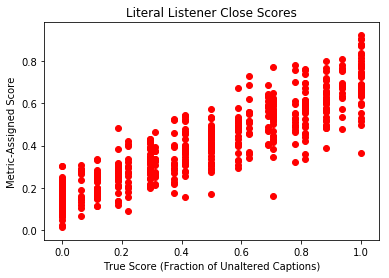

Pearson-r: (0.8855803265103172, 1.2285576536998764e-173)


In [53]:
plt.scatter(literal_listener_close_true_scores, literal_listener_close_model_scores, color="red")
plt.title("Literal Listener Close Scores")
plt.xlabel("True Score (Fraction of Unaltered Captions)")
plt.ylabel("Metric-Assigned Score")
plt.show()
print("Pearson-r:",stats.pearsonr(literal_listener_close_true_scores, literal_listener_close_model_scores))

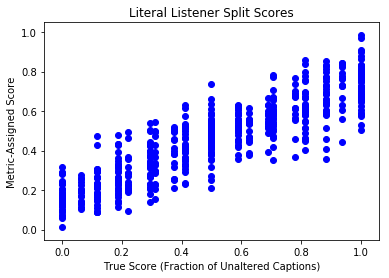

Pearson-r: (0.8895371224286676, 2.433177952581813e-177)


In [54]:
plt.scatter(literal_listener_split_true_scores, literal_listener_split_model_scores, color="blue")
plt.title("Literal Listener Split Scores")
plt.xlabel("True Score (Fraction of Unaltered Captions)")
plt.ylabel("Metric-Assigned Score")
plt.show()
print("Pearson-r:",stats.pearsonr(literal_listener_split_true_scores, literal_listener_split_model_scores))

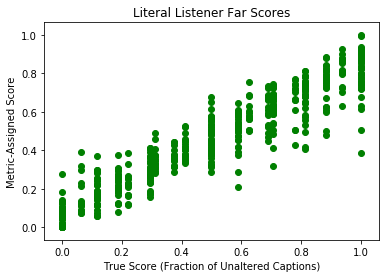

Pearson-r: (0.9403582470450493, 2.548266847876622e-243)


In [55]:
plt.scatter(literal_listener_far_true_scores, literal_listener_far_model_scores, color="green")
plt.title("Literal Listener Far Scores")
plt.xlabel("True Score (Fraction of Unaltered Captions)")
plt.ylabel("Metric-Assigned Score")
plt.show()
print("Pearson-r:",stats.pearsonr(literal_listener_far_true_scores, literal_listener_far_model_scores))

In [56]:
literal_listener_close_composite = composite_score(literal_listener_close)
literal_listener_split_composite = composite_score(literal_listener_split)
literal_listener_far_composite   = composite_score(literal_listener_far)

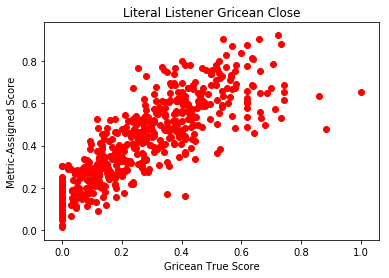

Pearson-r: (0.8222790118579052, 3.5192899893887893e-128)


In [57]:
plt.scatter(literal_listener_close_composite, literal_listener_close_model_scores, color="red")
plt.title("Literal Listener Gricean Close")
plt.xlabel("Gricean True Score")
plt.ylabel("Metric-Assigned Score")
plt.show()
print("Pearson-r:",stats.pearsonr(literal_listener_close_composite, literal_listener_close_model_scores))

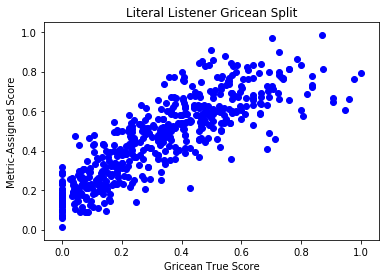

Pearson-r: (0.847045853708342, 1.8201761588096475e-143)


In [58]:
plt.scatter(literal_listener_split_composite, literal_listener_split_model_scores, color="blue")
plt.title("Literal Listener Gricean Split")
plt.xlabel("Gricean True Score")
plt.ylabel("Metric-Assigned Score")
plt.show()
print("Pearson-r:",stats.pearsonr(literal_listener_split_composite, literal_listener_split_model_scores))

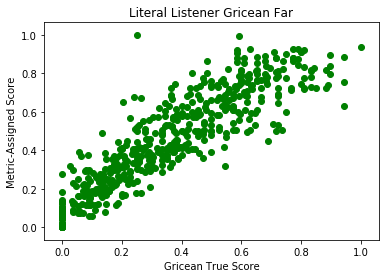

Pearson-r: (0.8928549561648225, 1.4803274435084762e-180)


In [59]:
plt.scatter(literal_listener_far_composite, literal_listener_far_model_scores, color="green")
plt.title("Literal Listener Gricean Far")
plt.xlabel("Gricean True Score")
plt.ylabel("Metric-Assigned Score")
plt.show()
print("Pearson-r:",stats.pearsonr(literal_listener_far_composite, literal_listener_far_model_scores))

# Imaginative Listener

In [62]:
# 4. Imaginative Listener
def imaginative_listener(train=False, model_file="../model/imaginative_listener_with_distractors_linear100hd5epoch_GLOVE_MSE.params"):
    print("Initializing featurizers")
    caption_phi = caption_featurizers.CaptionFeaturizer(tokenizer=caption_featurizers.EndingTokenizer)
    color_phi = ColorFeaturizer(color_phi_fourier, "rgb", normalized=True)

    def target_color_target(data_entry):
        return np.array(data_entry.colors[0].rgb_norm)

    feature_handler = FeatureHandler(train_data, dev_data_synth, caption_phi, color_phi, target_fn=target_color_target,
                                randomized_colors=False)

    print("Obtaining training features") # get features even if you're runnning the pretrained model for example
    train_features = feature_handler.train_features()
    train_targets = feature_handler.train_targets()

    imaginative_model = ImaginativeListener(ColorGenerator, criterion=torch.nn.CosineEmbeddingLoss,
                            optimizer=torch.optim.Adam, lr=0.004, num_epochs=5)

    MSELossSum = lambda: nn.MSELoss(reduction='sum') # sorry for this ugliness..... but this is me passing a parameter to the loss func
    imaginative_model = ImaginativeListener(ColorGenerator, criterion=MSELossSum,
                                optimizer=torch.optim.Adam, lr=0.004, num_epochs=5, use_color=True)
    imaginative_model.init_model(embed_dim=100, hidden_dim=100, vocab_size=feature_handler.caption_featurizer.caption_indexer.size,
                    color_in_dim=54, color_hidden_dim=100, weight_matrix=caption_featurizers.get_pretrained_glove(feature_handler.caption_featurizer.caption_indexer.idx2word.items(), 100, prefix=True))

    if train:
        print("Training model and saving to {}:".format(model_file))
        imaginative_model.fit(train_features, train_targets)
        imaginative_model.save_model(model_file)
    else:
        print("Loading pretrained model")
        imaginative_model.load_model(model_file)

    print("Evaluating model")
    output_to_score_de = lambda outputs, targets: np.array([delta_e_dist(outputs[i], targets[i]) for i in range(len(targets))])
    # we want to score based on the model's predictions at the TARGET indices not listener clicked indices,
    # so we change the feature_handler's target function to do that:
    my_score_model = partial(score_model, speaker=Speaker.BY_GAME_ID_COND, return_df=True, score=Score.COMPOSITE)
    result = evaluate_model(dev_data_synth, feature_handler, imaginative_model, output_to_score_de, my_score_model, accuracy=False)
    
    return result

In [132]:
#model_file_temp = "../model/imaginative_listener_with_distractors_linear100hd5epoch_GLOVE_MSE_sigmoid.params"

In [139]:
x = imaginative_listener() #<- get original plots back by 
#x = imaginative_listener(model_file=model_file_temp)
imaginative_listener_eval = x[1]
# first get just correlation between all model scores 
il_true_scores = imaginative_listener_eval.groupby('gameid').numOutcome.mean()
il_model_scores = imaginative_listener_eval.groupby('gameid').model_scores.mean()

Initializing featurizers
Obtaining training features
Loading pretrained model
Evaluating model
Got here to composite score
((-0.2281502959821442, 9.18489275263942e-20),           gameid  roundNum  numOutcome  \
0        synth-0         1           1   
1        synth-0         2           1   
2        synth-0         3           1   
3        synth-0         4           1   
4        synth-0         5           1   
5        synth-0         6           1   
6        synth-0         7           1   
7        synth-0         8           1   
8        synth-0         9           1   
9        synth-0        10           1   
10       synth-0        11           1   
11       synth-0        12           1   
12       synth-0        13           1   
13       synth-0        14           1   
14       synth-0        15           1   
15       synth-0        16           1   
16       synth-0        17           1   
17       synth-0        18           1   
18       synth-0        19       

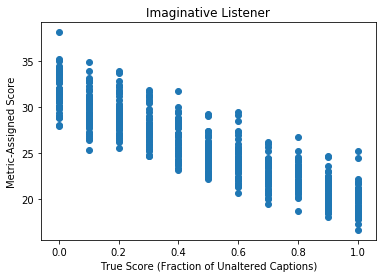

(-0.8924668739410604, 3.564000129572897e-180)

In [65]:
plt.scatter(il_true_scores, il_model_scores)
plt.title("Imaginative Listener")
plt.xlabel("True Score (Fraction of Unaltered Captions)")
plt.ylabel("Metric-Assigned Score")
plt.show()
stats.pearsonr(il_true_scores, il_model_scores)

In [66]:
# composite
il_true_scores_composite = composite_score(imaginative_listener_eval)

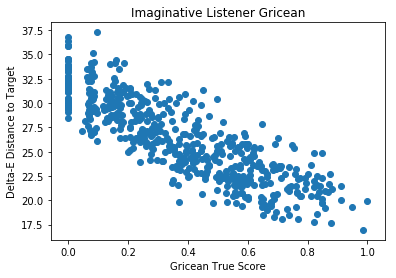

(-0.8413014385985875, 1.0907684900090363e-139)

In [67]:
plt.scatter(il_true_scores_composite, il_model_scores)
plt.title("Imaginative Listener Gricean")
plt.xlabel("Gricean True Score")
plt.ylabel("Delta-E Distance to Target")
plt.show()
stats.pearsonr(il_true_scores_composite, il_model_scores)

In [68]:
# separate out conditions
imaginative_listener_close = imaginative_listener_eval[literal_listener_eval_composite.condition == "close"]
imaginative_listener_split = imaginative_listener_eval[literal_listener_eval_composite.condition == "split"]
imaginative_listener_far = imaginative_listener_eval[literal_listener_eval_composite.condition == "far"]

imaginative_listener_close_true_scores = imaginative_listener_close.groupby('gameid').numOutcome.mean()
imaginative_listener_close_model_scores = imaginative_listener_close.groupby('gameid').model_scores.mean()

imaginative_listener_split_true_scores =  imaginative_listener_split.groupby('gameid').numOutcome.mean()
imaginative_listener_split_model_scores = imaginative_listener_split.groupby('gameid').model_scores.mean()

imaginative_listener_far_true_scores =  imaginative_listener_far.groupby('gameid').numOutcome.mean()
imaginative_listener_far_model_scores = imaginative_listener_far.groupby('gameid').model_scores.mean()

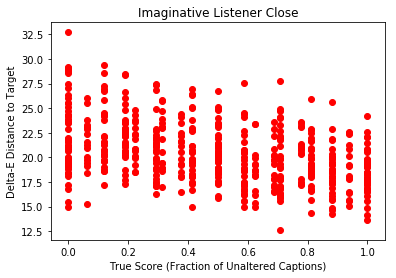

(-0.4126618687835607, 1.1214587076681742e-22)

In [69]:
plt.scatter(imaginative_listener_close_true_scores, imaginative_listener_close_model_scores, color="red")
plt.title("Imaginative Listener Close")
plt.xlabel("True Score (Fraction of Unaltered Captions)")
plt.ylabel("Delta-E Distance to Target")
plt.show()
stats.pearsonr(imaginative_listener_close_true_scores, imaginative_listener_close_model_scores)

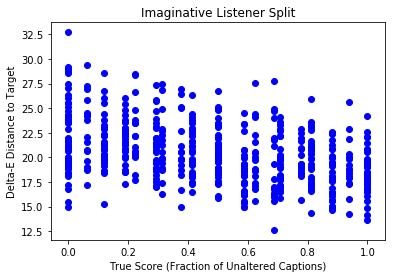

(-0.41148912470034615, 1.5177028781302751e-22)

In [70]:
plt.scatter(imaginative_listener_split_true_scores, imaginative_listener_close_model_scores, color="blue")
plt.title("Imaginative Listener Split")
plt.xlabel("True Score (Fraction of Unaltered Captions)")
plt.ylabel("Delta-E Distance to Target")
plt.show()
stats.pearsonr(imaginative_listener_split_true_scores, imaginative_listener_close_model_scores)

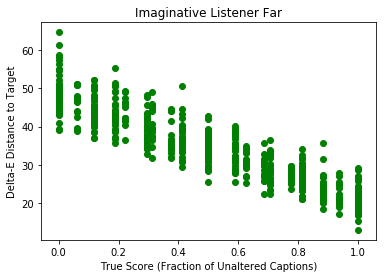

(-0.9110253978358639, 2.807019975030186e-200)

In [71]:
plt.scatter(imaginative_listener_far_true_scores, imaginative_listener_far_model_scores, color="green")
plt.title("Imaginative Listener Far")
plt.xlabel("True Score (Fraction of Unaltered Captions)")
plt.ylabel("Delta-E Distance to Target")
plt.show()
stats.pearsonr(imaginative_listener_far_true_scores, imaginative_listener_far_model_scores)

In [72]:
imaginative_listener_close_true_scores_composite = composite_score(imaginative_listener_close)
imaginative_listener_split_true_scores_composite = composite_score(imaginative_listener_split)
imaginative_listener_far_true_scores_composite   = composite_score(imaginative_listener_far)

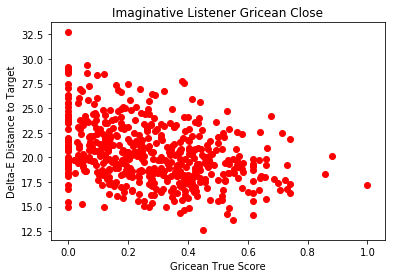

(-0.3541684434969253, 1.0054740992862474e-16)

In [73]:
plt.scatter(imaginative_listener_close_true_scores_composite, imaginative_listener_close_model_scores, color="red")
plt.title("Imaginative Listener Gricean Close")
plt.xlabel("Gricean True Score")
plt.ylabel("Delta-E Distance to Target")
plt.show()
stats.pearsonr(imaginative_listener_close_true_scores_composite, imaginative_listener_close_model_scores)

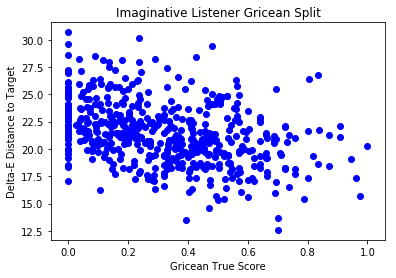

(-0.3734966054617926, 1.4685548875668313e-18)

In [74]:
plt.scatter(imaginative_listener_split_true_scores_composite, imaginative_listener_split_model_scores, color="blue")
plt.title("Imaginative Listener Gricean Split")
plt.xlabel("Gricean True Score")
plt.ylabel("Delta-E Distance to Target")
plt.show()
stats.pearsonr(imaginative_listener_split_true_scores_composite, imaginative_listener_split_model_scores)

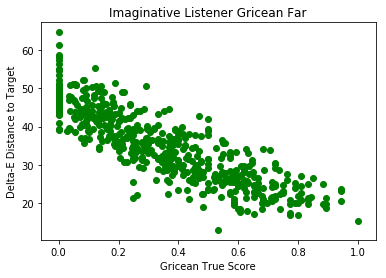

(-0.8566722581820054, 3.690412032566412e-150)

In [75]:
plt.scatter(imaginative_listener_far_true_scores_composite, imaginative_listener_far_model_scores, color="green")
plt.title("Imaginative Listener Gricean Far")
plt.xlabel("Gricean True Score")
plt.ylabel("Delta-E Distance to Target")
plt.show()
stats.pearsonr(imaginative_listener_far_true_scores_composite, imaginative_listener_far_model_scores)

# Pragmatic Listener

In [15]:
def literal_speaker_experiment(train=False, evaluate=True, epochs=5, color_in_dim = 54, color_dim = 100, embed_dim = 100, hidden_dim = 100, lr = 0.004, model_file="model/literal_speaker_5epoch.params"):
    # Initializing featurizers
    print("Initializing featurizers")
    caption_phi = caption_featurizers.CaptionFeaturizer(tokenizer=caption_featurizers.EndingTokenizer)  # we'll use the EndingTokenizer in order to have common training data, but should technically be WhitespaceTokenizer

    color_phi = ColorFeaturizer(color_phi_fourier, "hsv", normalized=True) # speaker uses hsv 
    
    # speaker's target is to predict tokens following the SOS token
    def speaker_target(data_entry):
        _, caption_ids = caption_phi.to_string_features(data_entry.caption) # this probably works...
        target = caption_ids[1:]
        return target

    feature_handler = FeatureHandler(train_data, dev_data, caption_phi, color_phi, target_fn=speaker_target, randomized_colors=False)

    print("Obtaining training features")
    train_features = feature_handler.train_features()
    train_targets = feature_handler.train_targets()

    print("Initializing model")
    model = LiteralSpeaker(CaptionGenerator, optimizer=torch.optim.Adam, lr=lr, num_epochs=epochs)
    #lit_speaker = Speaker(color_embed_dim, caption_phi.caption_indexer.size, embed_dim, hidden_dim)
    model.init_model(color_in_dim=color_in_dim, color_dim=color_dim,
                                  vocab_size=caption_phi.caption_indexer.size, embed_dim=embed_dim,
                                 speaker_hidden_dim=hidden_dim)
    if train:
        print("Training model and saving to {}:".format(model_file))
        model.fit(train_features, train_targets)
        model.save_model(model_file)
    else:
        print("Loading pretrained model")
        model.load_model(model_file)

    if evaluate:
        # do some kind of evaluation...
        print("TODO: No evaluation currently set for speaker model.")
    return model

In [101]:
def pragmatic_listener(evaluate=True,
        literal_model_file="../model/best_literal_listener.params",
        speaker_model_file="../model/literal_speaker_30epochGLOVE.params",
        alpha=0.544,
        composite=True):
    color_phi_listener = ColorFeaturizer(color_phi_fourier, "rgb", normalized=True)
    color_phi_speaker = ColorFeaturizer(color_phi_fourier, "hsv", normalized=True)
    caption_phi = caption_featurizers.CaptionFeaturizer(tokenizer=caption_featurizers.EndingTokenizer)
    feature_handler_listener = FeatureHandler(train_data, dev_data_synth, caption_phi, color_phi_listener)
    feature_handler_speaker = FeatureHandler(train_data, dev_data_synth, caption_phi, color_phi_speaker)
    print("Loading literal listener")
    listener_model = literal_listener_experiment(train=False, evaluate=False, model_file=literal_model_file)
    print("Loading literal speaker")
    speaker_model = literal_speaker_experiment(train=False, evaluate=False, model_file=speaker_model_file)
    pragmatic_model = PragmaticListener(listener_model, speaker_model,alpha=alpha)
    if not evaluate:
        return pragmatic_model
    else:
        output_to_score = lambda model_outputs, targets: np.exp(model_outputs[np.arange(len(model_outputs)), targets]) # get the model's predicted probablity at each target index and use that as the score
        if composite:
            my_score_model = partial(score_model, speaker=Speaker.BY_GAME_ID_COND, return_df=True, score=Score.COMPOSITE)
        else:
            my_score_model = partial(score_model, speaker=Speaker.BY_GAME_ID_COND, return_df=True)
        return evaluate_model(dev_data_synth, feature_handler_listener, pragmatic_model, output_to_score,
                              my_score_model, feature_handler_2=feature_handler_speaker)

In [28]:
xp = pragmatic_listener()

Loading literal listener
Initializing featurizers
Obtaining training features
Initializing model
Loading pretrained model
Loading literal speaker
Initializing featurizers
Obtaining training features
Initializing model
Loading pretrained model
Got here to composite score
((0.8544331645697395, 0.0),           gameid  roundNum  numOutcome  \
0        synth-0         1           1   
1        synth-0         2           1   
2        synth-0         3           1   
3        synth-0         4           1   
4        synth-0         5           1   
5        synth-0         6           1   
6        synth-0         7           1   
7        synth-0         8           1   
8        synth-0         9           1   
9        synth-0        10           1   
10       synth-0        11           1   
11       synth-0        12           1   
12       synth-0        13           1   
13       synth-0        14           1   
14       synth-0        15           1   
15       synth-0        16   

In [29]:
pragmatic_listener_eval_composite = xp[1]
# first get just correlation between all model scores 
pl_true_scores = pragmatic_listener_eval_composite.groupby('gameid').numOutcome.mean()
pl_model_scores = pragmatic_listener_eval_composite.groupby('gameid').model_scores.mean()

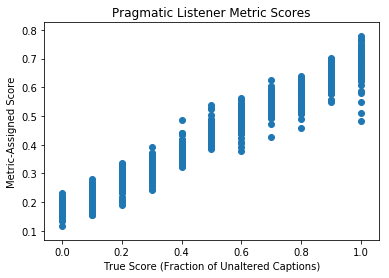

(0.9699095521827794, 3.752646e-318)

In [30]:
plt.scatter(pl_true_scores, pl_model_scores)
plt.title("Pragmatic Listener Metric Scores")
plt.xlabel("True Score (Fraction of Unaltered Captions)")
plt.ylabel("Metric-Assigned Score")
plt.show()
stats.pearsonr(pl_true_scores, pl_model_scores)

In [32]:
stats.pearsonr(pl_true_scores, pl_model_scores)

(0.9699095521827794, 3.752646e-318)

In [33]:
# now calculate the composite score from the eval_df we get back:
def composite_score(eval_df, speaker="gameid"):
    mean_scores = eval_df.groupby(speaker).numOutcome.mean()
    mean_numCleanWords = eval_df.groupby(speaker).numCleanWords.mean()
    mean_clkTime = eval_df.groupby(speaker).clkTime.mean()
    true_scores = mean_scores / mean_clkTime / mean_numCleanWords
    max_score = true_scores.max()
    true_scores /= max_score # normalize the scores
    return true_scores

pl_true_scores_composite = composite_score(pragmatic_listener_eval_composite)
pragmatic_listener_eval_composite.groupby('gameid').numOutcome.mean()
pl_model_scores_composite = pragmatic_listener_eval_composite.groupby('gameid').model_scores.mean()

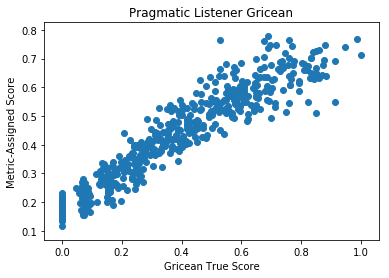

(0.9454068188992509, 6.35963372227692e-253)

In [34]:
plt.scatter(pl_true_scores_composite, pl_model_scores_composite)
plt.title("Pragmatic Listener Gricean")
plt.xlabel("Gricean True Score")
plt.ylabel("Metric-Assigned Score")
plt.show()
stats.pearsonr(pl_true_scores_composite, pl_model_scores_composite)

In [36]:
# separate out conditions
pragmatic_listener_close = pragmatic_listener_eval_composite[pragmatic_listener_eval_composite.condition == "close"]
pragmatic_listener_split = pragmatic_listener_eval_composite[pragmatic_listener_eval_composite.condition == "split"]
pragmatic_listener_far = pragmatic_listener_eval_composite[pragmatic_listener_eval_composite.condition == "far"]

pragmatic_listener_close_true_scores = pragmatic_listener_close.groupby('gameid').numOutcome.mean()
pragmatic_listener_close_model_scores = pragmatic_listener_close.groupby('gameid').model_scores.mean()

pragmatic_listener_split_true_scores =  pragmatic_listener_split.groupby('gameid').numOutcome.mean()
pragmatic_listener_split_model_scores = pragmatic_listener_split.groupby('gameid').model_scores.mean()

pragmatic_listener_far_true_scores =  pragmatic_listener_far.groupby('gameid').numOutcome.mean()
pragmatic_listener_far_model_scores = pragmatic_listener_far.groupby('gameid').model_scores.mean()

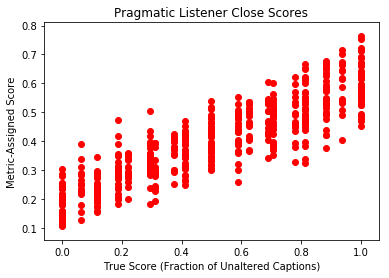

Pearson-r: (0.8858018376315718, 7.686260330549365e-174)


In [38]:
plt.scatter(pragmatic_listener_close_true_scores, pragmatic_listener_close_model_scores, color="red")
plt.title("Pragmatic Listener Close Scores")
plt.xlabel("True Score (Fraction of Unaltered Captions)")
plt.ylabel("Metric-Assigned Score")
plt.show()
print("Pearson-r:",stats.pearsonr(pragmatic_listener_close_true_scores, pragmatic_listener_close_model_scores))

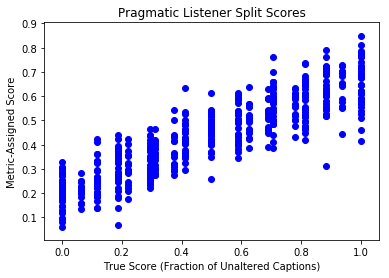

Pearson-r: (0.8918621033490376, 1.3920875235678803e-179)


In [40]:
plt.scatter(pragmatic_listener_split_true_scores, pragmatic_listener_split_model_scores, color="blue")
plt.title("Pragmatic Listener Split Scores")
plt.xlabel("True Score (Fraction of Unaltered Captions)")
plt.ylabel("Metric-Assigned Score")
plt.show()
print("Pearson-r:",stats.pearsonr(pragmatic_listener_split_true_scores, pragmatic_listener_split_model_scores))

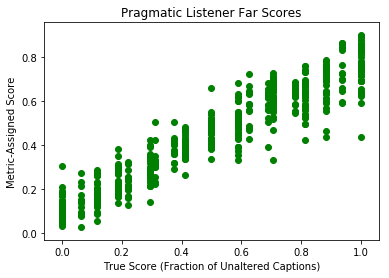

Pearson-r: (0.9457291236238072, 1.4442167811336624e-253)


In [41]:
plt.scatter(pragmatic_listener_far_true_scores, pragmatic_listener_far_model_scores, color="green")
plt.title("Pragmatic Listener Far Scores")
plt.xlabel("True Score (Fraction of Unaltered Captions)")
plt.ylabel("Metric-Assigned Score")
plt.show()
print("Pearson-r:",stats.pearsonr(pragmatic_listener_far_true_scores, pragmatic_listener_far_model_scores))

In [42]:
pragmatic_listener_close_composite = composite_score(pragmatic_listener_close)
pragmatic_listener_split_composite = composite_score(pragmatic_listener_split)
pragmatic_listener_far_composite   = composite_score(pragmatic_listener_far)

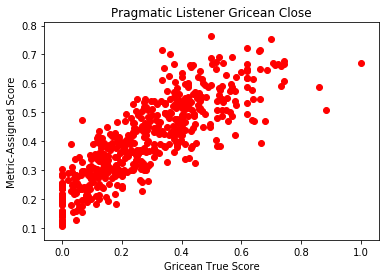

Pearson-r: (0.8407882979597079, 2.3325992083172165e-139)


In [43]:
plt.scatter(pragmatic_listener_close_composite, pragmatic_listener_close_model_scores, color="red")
plt.title("Pragmatic Listener Gricean Close")
plt.xlabel("Gricean True Score")
plt.ylabel("Metric-Assigned Score")
plt.show()
print("Pearson-r:",stats.pearsonr(pragmatic_listener_close_composite, pragmatic_listener_close_model_scores))

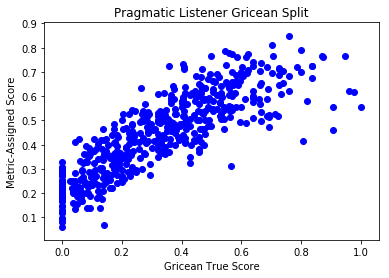

Pearson-r: (0.8431642392626038, 6.75186359233317e-141)


In [44]:
plt.scatter(pragmatic_listener_split_composite, pragmatic_listener_split_model_scores, color="blue")
plt.title("Pragmatic Listener Gricean Split")
plt.xlabel("Gricean True Score")
plt.ylabel("Metric-Assigned Score")
plt.show()
print("Pearson-r:",stats.pearsonr(pragmatic_listener_split_composite, pragmatic_listener_split_model_scores))

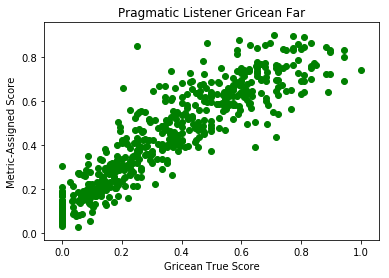

Pearson-r: (0.903230019594828, 2.438149864935409e-191)


In [45]:
plt.scatter(pragmatic_listener_far_composite, pragmatic_listener_far_model_scores, color="green")
plt.title("Pragmatic Listener Gricean Far")
plt.xlabel("Gricean True Score")
plt.ylabel("Metric-Assigned Score")
plt.show()
print("Pearson-r:",stats.pearsonr(pragmatic_listener_far_composite, pragmatic_listener_far_model_scores))

# Hyperparameter search for Pragmatic

Pragmatic is a bit different in that we don't need to train, so won't use the Hyperparameter Search notebook.  It relies on literal_listener_experiment and literal_speaker_experiment


In [79]:
import pickle

In [113]:
for alpha in [0.5, 1.0, 2.0]:
    with open("pragmatic-hyp/alpha="+str(alpha)+"-pragmatic-eval.pickle", 'wb') as f:
        print("Evaluating alpha =", alpha)
        xp = pragmatic_listener(alpha=alpha)
        pickle.dump(xp, f)

Evaluating alpha = 2.0
Loading literal listener
Initializing featurizers
Obtaining training features
Initializing model
Loading pretrained model
Loading literal speaker
Initializing featurizers
Obtaining training features
Initializing model
Loading pretrained model
Got here to composite score
((0.8758469377392254, 0.0),           gameid  roundNum  numOutcome  \
0        synth-0         1           1   
1        synth-0         2           1   
2        synth-0         3           1   
3        synth-0         4           1   
4        synth-0         5           1   
5        synth-0         6           1   
6        synth-0         7           1   
7        synth-0         8           1   
8        synth-0         9           1   
9        synth-0        10           1   
10       synth-0        11           1   
11       synth-0        12           1   
12       synth-0        13           1   
13       synth-0        14           1   
14       synth-0        15           1   
15    